# Understanding High Dimensional Data With Projections

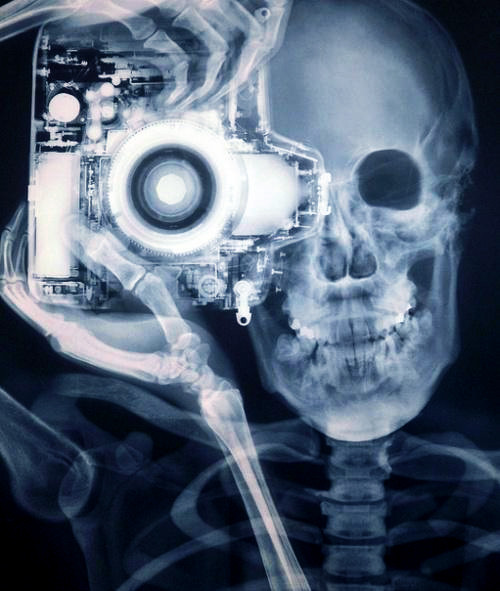

In [2]:
from IPython.core.display import Image
Image("X-ray_20140728.jpg")

In [3]:
#imports and convenience functions

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"]=(8,8)


def remove_ticks_and_labels(fig):
    axes = fig.axes
    for ax in axes:
        for label_set in [ax.get_xticklabels(), ax.get_yticklabels()]:
            for label in label_set:
                label.set_visible(False)
                label.set_fontsize(0.0)
        for tick_set in [ax.get_xticklines(), ax.get_yticklines()]:
            for tick in tick_set:
                tick.set_visible(False)



# Why Use Projections?

* Grokable
 - The transformation is simple, even "intuitive" 
 - we have lots of powerful tools for reasoning about 1-dimensional distributions (e.g. histograms, ks-tests etc)

* Flexible, Powerful

 - Fourier Transforms, Band Pass Filters, Convolution etc etc can all be thought of as projection matrices)




A picture may be worth a thousand words but a csv with a thousand columns may not be worth anything unless you make it into pictures! 

# Important Projections

* Identity <br>
pick a column and look at it!

* Principal Component Analysis   
directions with biggest spread

* Linear Discriminant Analysis   
"mean" direction of category difference

* Linear Support Vector Machines <br>
"median" direction of category difference

# Principal Component Analysis (PCA)

PCA decomposes a matrix M (e.g. our data matrix) into a product of matrices wtih nice properties.

$$ M = U ~ \Sigma ~ V^*$$

* $V$ holds the "principal vectors" which represent structures over column space.
* $\Sigma$ is the square root of the variance of our data projected onto the principal vectors.
* $U$ holds the "principal components" which are the rescaled projections of our data onto the principal vectors 


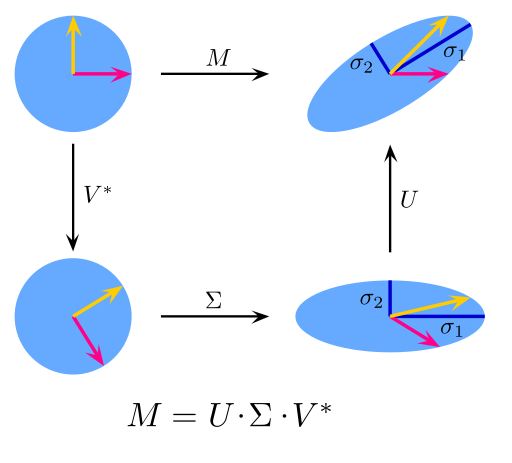

In [4]:
Image("512px-Singular-Value-Decomposition.svg.png", embed=True)

Image: By Georg-Johann - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=11342212

# Properties of PCA

* The principal vectors are the eigenvectors of the data covariance matrix

* PCA decorrelates variables. (The covariance matrix of the principal components is diagonal)

* keeping the first K principal components is mathematically equivalent to fitting a K dimensional hyperplane to your data using least squares.

* PCA is EXTREMELY sensitive to outliers (a corrolary to the fact the principal vectors are eigenvectors of the covariance matrix)

* PCA is very sensitive to rescaling of the columns (think before you z-score everything)


remember to talk about analogy of pca to discrete differentiation in 1d

# A little Fun With PCA

In [5]:
def multi_scatter(
    data, k, 
    upper_C=None, 
    lower_C=None,  
    cmap=None, 
    column_prefix="col ",
    hexbin_kwargs=None,
):
    if hexbin_kwargs is None:
        hexbin_kwargs = {}
    if k is None:
        k = max(6, data.shape[1])
    ndims = k
    if cmap is None:
        cmap = "afmhot"
    fig, ax = plt.subplots(ndims, ndims)
    for i in range(ndims):
        ax[ndims-1, i].set_xlabel("{} {}".format(column_prefix, i+1), fontsize=16)
        ax[i, 0].set_ylabel("{} {}".format(column_prefix, i+1), fontsize=16)
        for j in range(ndims):
            if i == j:
                ax[i,i].hist(data[:, i], 25)
            elif i < j:
                if upper_C is None:
                    ax[i,j].scatter(data[:, i], data[:, j], alpha=0.6)
                else:
                    ax[i,j].hexbin(data[:, i], data[:, j], C=upper_C, **hexbin_kwargs)
            else:
                ax[i, j].hexbin(data[:, i], data[:, j], cmap="afmhot", C=lower_C, **hexbin_kwargs)
    remove_ticks_and_labels(fig)


def captured_variance_plot(singular_values):
    variances = singular_values**2
    cum_variance = np.cumsum(variances)
    frac_cvar = cum_variance/cum_variance[-1]
    plt.plot(np.arange(1, len(singular_values)+1), frac_cvar)
    plt.xlabel("# of components", fontsize=16)
    plt.ylabel("Cumulative Captured Variance", fontsize=16)

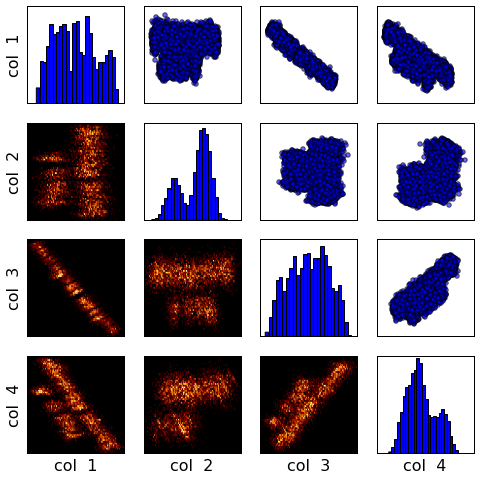

In [6]:
hidden_message = pd.read_csv("secret_message.csv").values 
#add a little noise to make things more interesting
noise = 0.01*(np.random.random(size=hidden_message.shape)-0.5)
hidden_message += noise
multi_scatter(hidden_message, k=4)


In [7]:
#cary out principal component analysis
msg_mean = np.mean(hidden_message, axis=0)
principal_components, projected_variance, principal_vectors = np.linalg.svd(hidden_message-msg_mean, full_matrices=False)


# Captured Variance


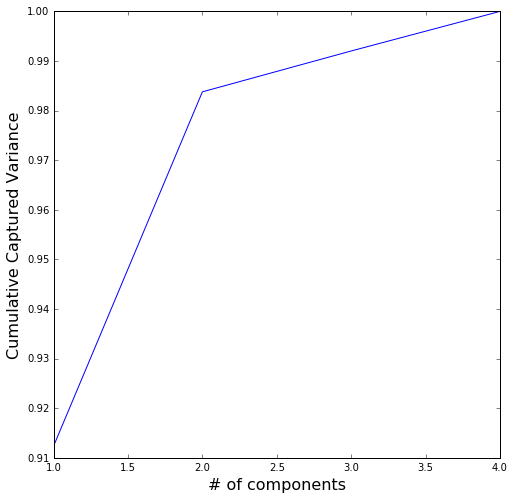

In [8]:
captured_variance_plot(projected_variance)

First Two Components Capture almost 99% of the variance! What could those be?

# Principal Component Distribution

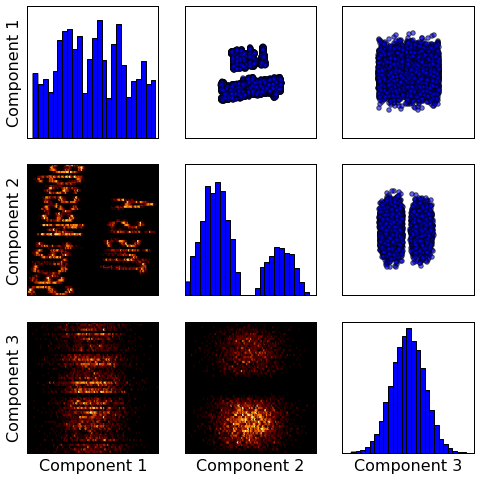

In [9]:
multi_scatter(principal_components, k=3, column_prefix="Component")

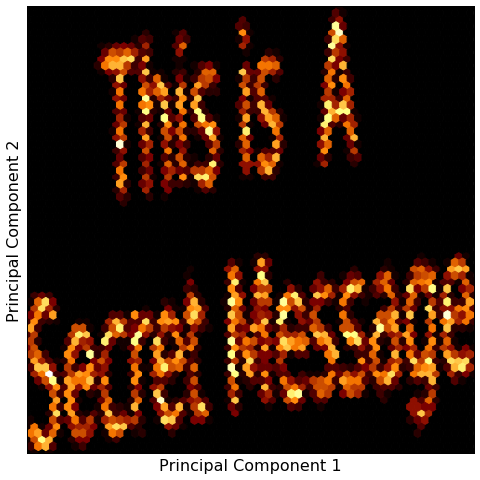

In [10]:
fig, ax = plt.subplots()
plt.hexbin(principal_components[:, 0], principal_components[:, 1], cmap="afmhot", gridsize=60)
remove_ticks_and_labels(fig)
plt.xlabel("Principal Component 1", fontsize=16)
plt.ylabel("Principal Component 2", fontsize=16)

# What if our noise dominates our signal?

In [12]:
hidden_message = pd.read_csv("secret_message_noisedom.csv").values 
#add a little noise to make things more interesting
noise = 0.01*(np.random.random(size=hidden_message.shape)-0.5)
hidden_message += noise

msg_mean = np.mean(hidden_message, axis=0)
principal_components, projected_variance, principal_vectors = np.linalg.svd(hidden_message-msg_mean, full_matrices=False)


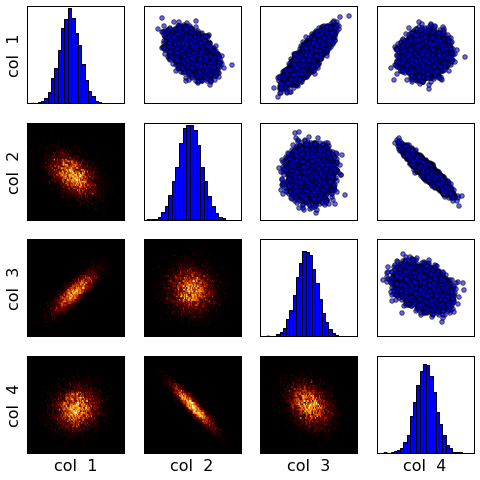

In [21]:
multi_scatter(hidden_message, k=4)


nice oval gaussian blobs! great! Thats exactly what PCA was designed for.

# Captured Variance

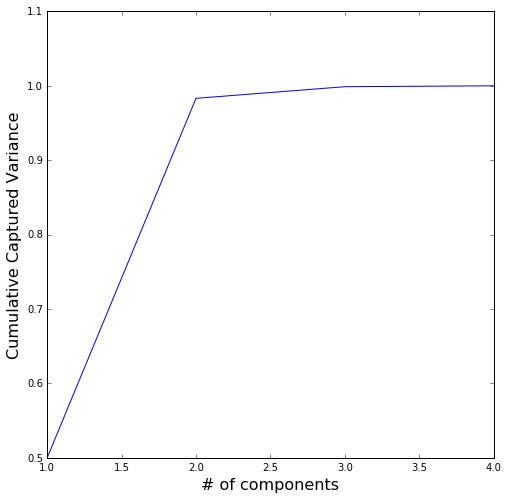

In [13]:
captured_variance_plot(projected_variance)

# Principal Component Distribution

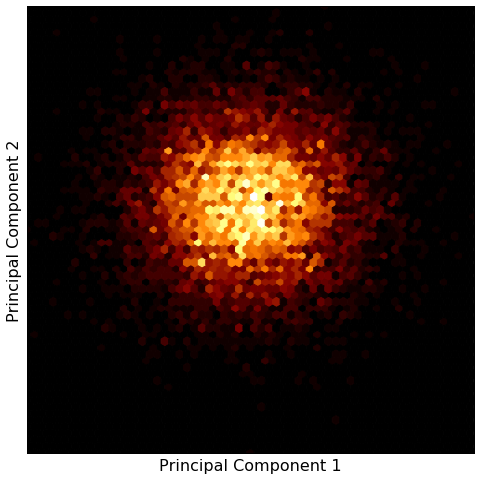

In [14]:
fig, ax = plt.subplots()
plt.hexbin(principal_components[:, 0], principal_components[:, 1], cmap="afmhot", gridsize=60)

remove_ticks_and_labels(fig)
plt.xlabel("Principal Component 1", fontsize=16)
plt.ylabel("Principal Component 2", fontsize=16)

# Lets look at the "noise" components anyway...

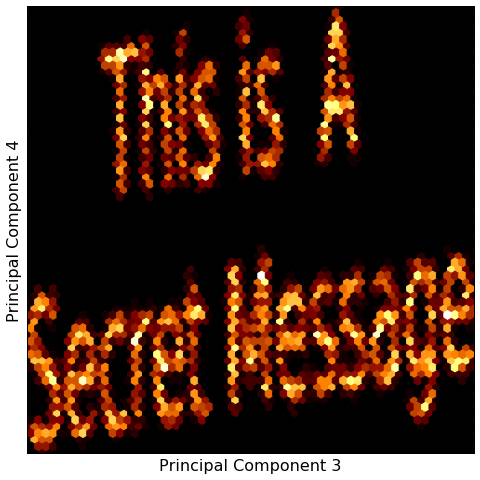

In [15]:
fig, ax = plt.subplots()
plt.hexbin(principal_components[:, 2], principal_components[:, 3], cmap="afmhot", gridsize=60)

remove_ticks_and_labels(fig)
plt.xlabel("Principal Component 3", fontsize=16)
plt.ylabel("Principal Component 4", fontsize=16)

## Low variance does not mean low importance!!!! 

# Hey! you didn't normalize your columns first!

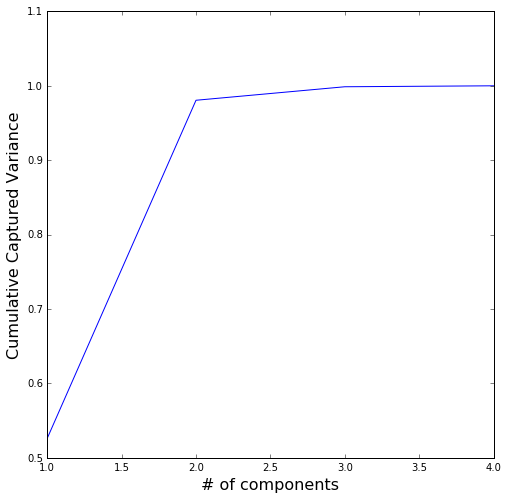

In [16]:
#cary out principal component analysis
msg_mean = np.mean(hidden_message, axis=0)
msg_std = np.std(hidden_message, axis=0)
principal_components, projected_variance, principal_vectors = np.linalg.svd(
    (hidden_message-msg_mean)/msg_std, 
    full_matrices=False
)


captured_variance_plot(projected_variance)

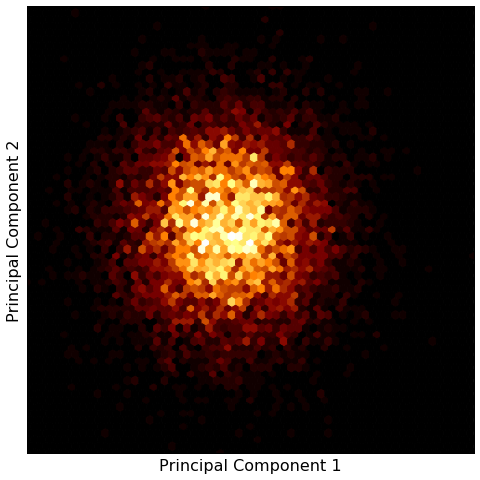

In [17]:
fig, ax = plt.subplots()
plt.hexbin(principal_components[:, 0], principal_components[:, 1], cmap="afmhot", gridsize=60)

remove_ticks_and_labels(fig)
plt.xlabel("Principal Component 1", fontsize=16)
plt.ylabel("Principal Component 2", fontsize=16)

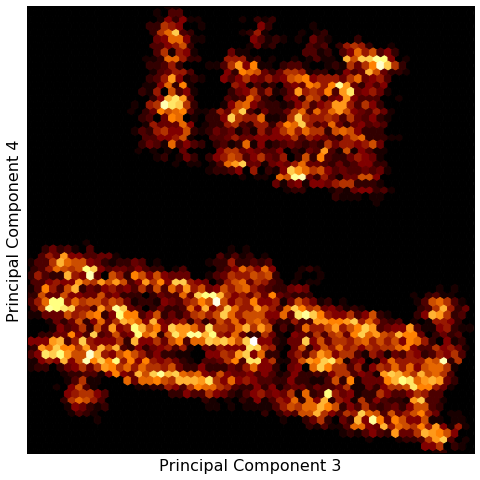

In [18]:
fig, ax = plt.subplots()
plt.hexbin(principal_components[:, 2], principal_components[:, 3], cmap="afmhot", gridsize=60)

remove_ticks_and_labels(fig)
plt.xlabel("Principal Component 3", fontsize=16)
plt.ylabel("Principal Component 4", fontsize=16)

Think before you normalize, variance may not be importance but sometimes it works out that way.

# What do we mean by "Projection" in D dimensions?

To project our data onto any 

When we say projection here we will mean any linear combination of our data. 

mathematically for a single row of data $\vec{x}$ we can calculate the projection $y$ onto a direction simply by taking the dot product of $\vec{x}$ and $\vec{p} (sum of the elementwise product of the two vectors). 

using bra-ket dirac notation thats



$$
y = <p~|~x>
$$


technically a projection is really only a projection if it has unit norm.

$$
<p~|~p> = 1
$$


# Kaggle MNIST Digit Image Recognition Dataset

a continuously running tutorial competition on the Kaggle web site.

https://www.kaggle.com/c/digit-recognizer

In [19]:
#load in the kaggle mnist digits recognition data set
digits = pd.read_csv("train.csv")

labels = digits["label"].values
digits.drop("label", 1, inplace=True)
images = digits.values

image_shape = 28, 28

# Example Digits



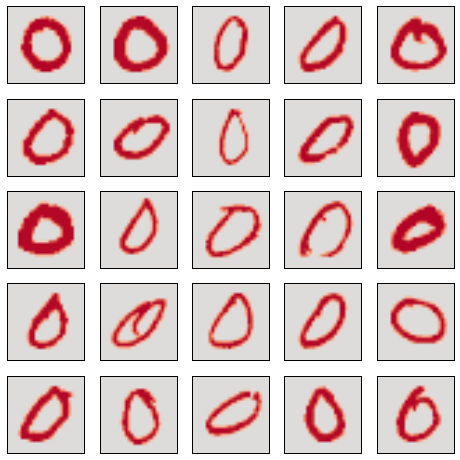

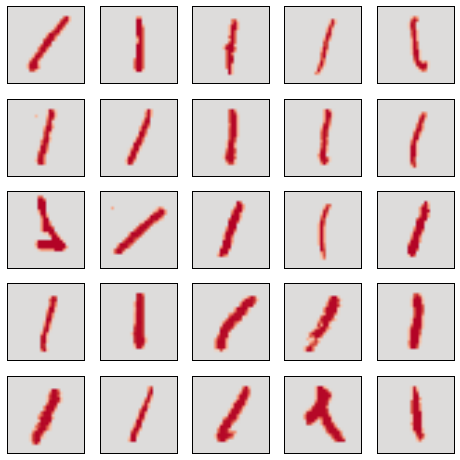

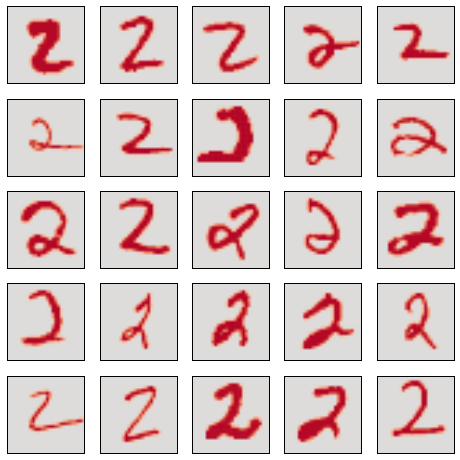

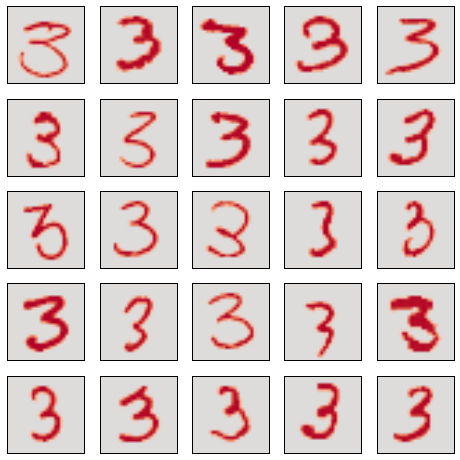

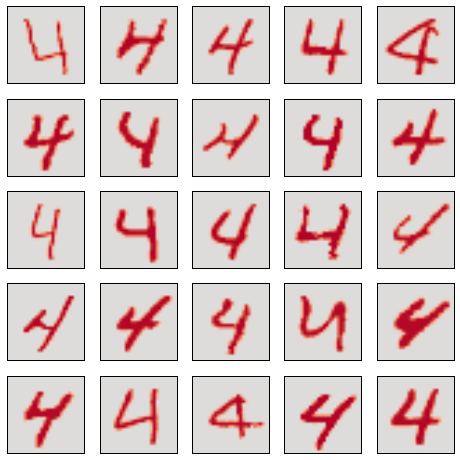

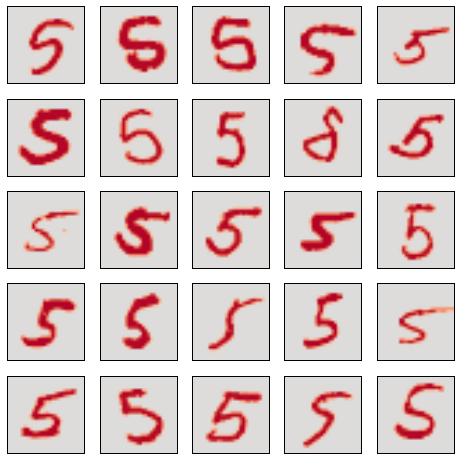

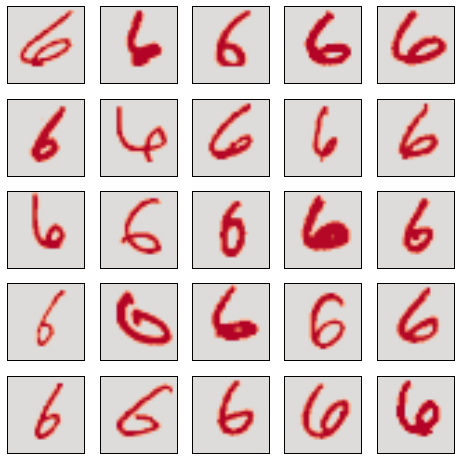

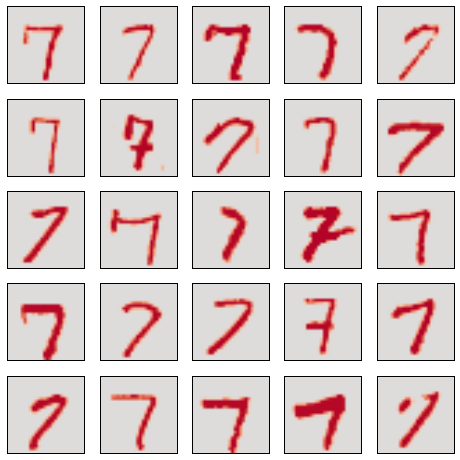

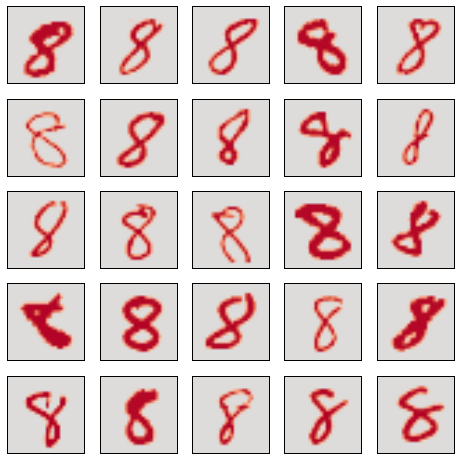

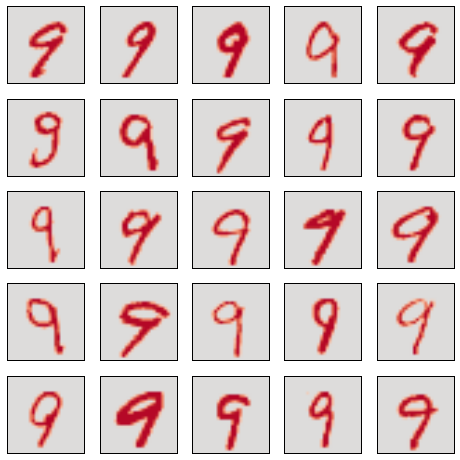

In [21]:
for digit in range(10):
    available_images = np.where(labels == digit)[0]
    fig, axes = plt.subplots(5,5)
    img_idx = 0
    for row in range(5):
        for col in range(5):
            axes[row, col].imshow(images[available_images[img_idx]].reshape((image_shape)), cmap="coolwarm", vmin=-256, vmax=256)
            img_idx += 1

    remove_ticks_and_labels(fig)
    plt.show()


# Mean Digit Image

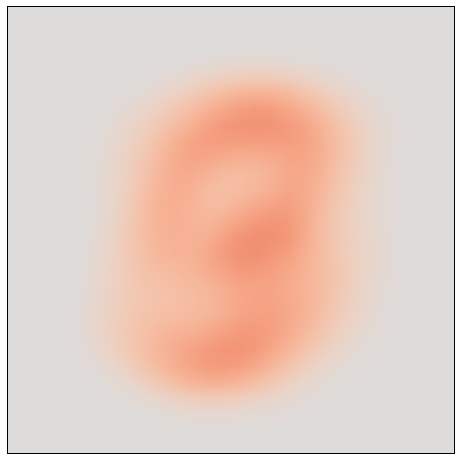

In [23]:
mean_digit = np.mean(images, axis=0)
fig, ax = plt.subplots()
ax.imshow(mean_digit.reshape(image_shape), cmap="coolwarm", vmin=-256, vmax=256)
remove_ticks_and_labels(fig)

# Mean Centered Images

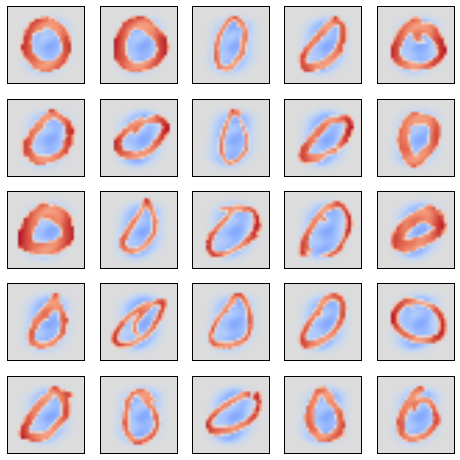

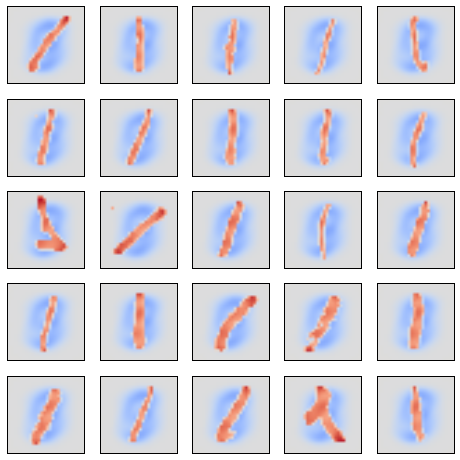

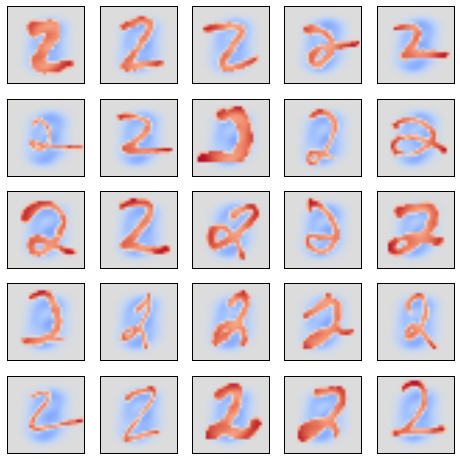

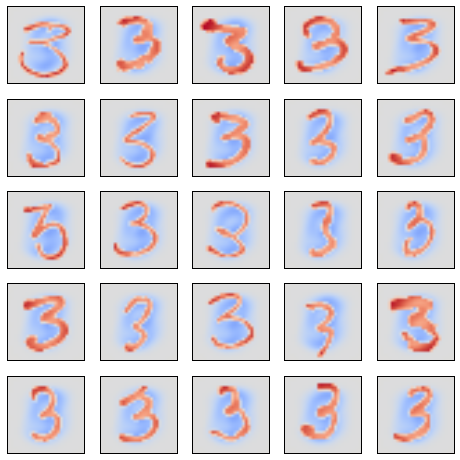

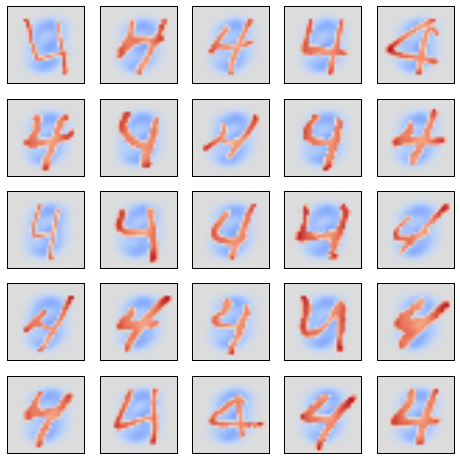

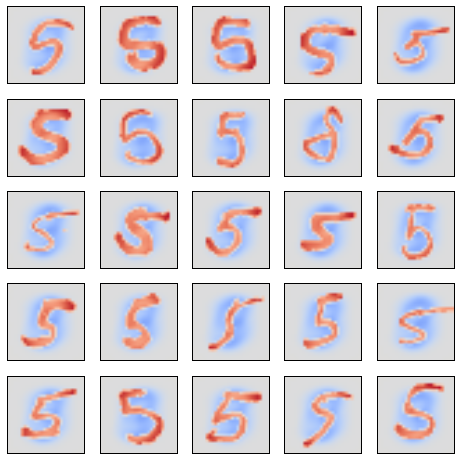

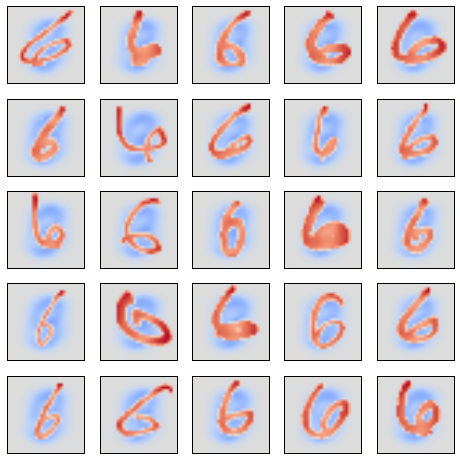

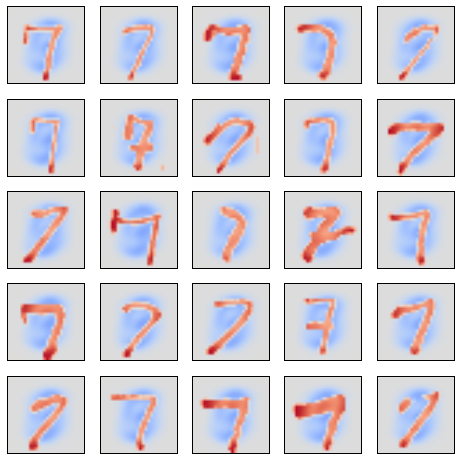

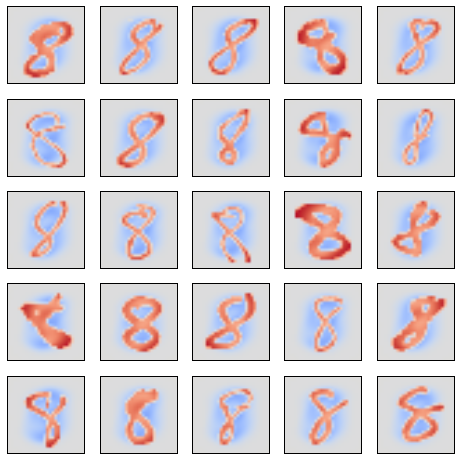

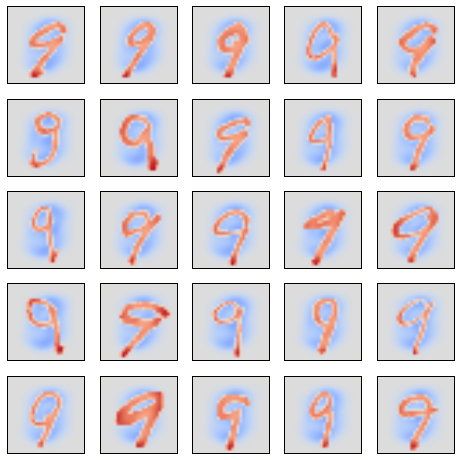

In [24]:
for digit in range(10):
    available_images = np.where(labels == digit)[0]
    fig, axes = plt.subplots(5,5)
    img_idx = 0
    for row in range(5):
        for col in range(5):
            axes[row, col].imshow((images[available_images[img_idx]]-mean_digit).reshape((image_shape)), cmap="coolwarm", vmin=-256, vmax=256)
            img_idx += 1

    remove_ticks_and_labels(fig)
    plt.show()

# Digit PCA

In [25]:
image_std = np.std(images, axis=0)
variance_smoothing = 2.0 #don't blow up the variance of boring pixels too much
whitened_images = (images-mean_digit)/(image_std + variance_smoothing)

#carry out principal component analysis
#we only use some of the digits to make it faster
image_mask = np.random.random(len(images)) < 0.1
principal_components, projected_variance, principal_vectors = np.linalg.svd(whitened_images[image_mask], full_matrices=False)


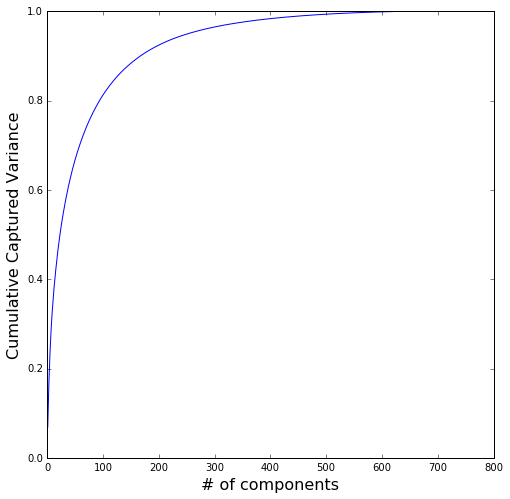

In [26]:
captured_variance_plot(projected_variance)

# Distribution of Principal Components

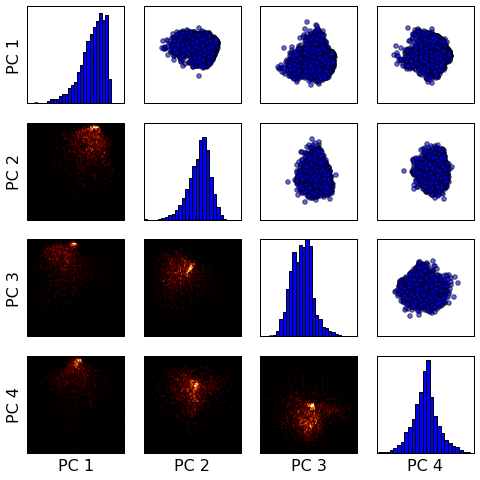

In [27]:
multi_scatter(principal_components, k=4, column_prefix="PC")

# Can we use PCA to separate our categories?

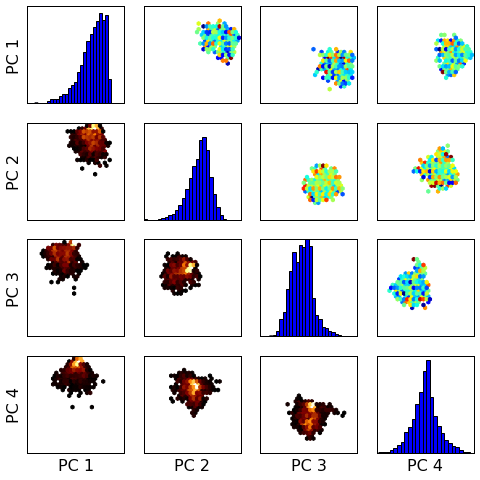

In [28]:
multi_scatter(
    principal_components, 
    k=4, 
    column_prefix="PC", 
    upper_C=labels, 
    hexbin_kwargs=dict(gridsize=30, mincnt=10)
)

# The Principal Digits (principal Vectors)

Principal Vector 1


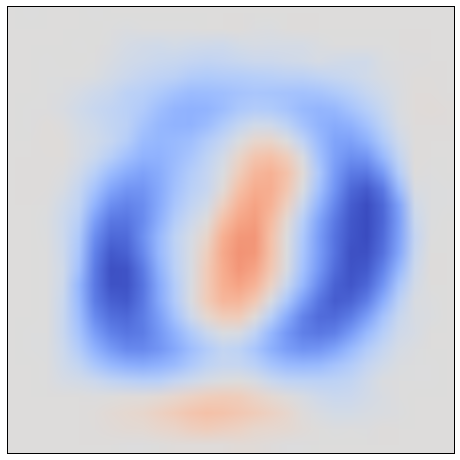

Principal Vector 2


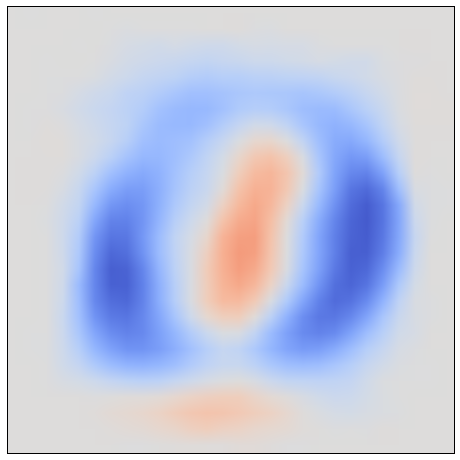

Principal Vector 3


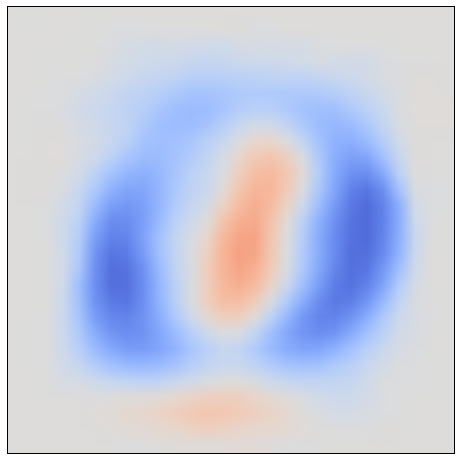

Principal Vector 4


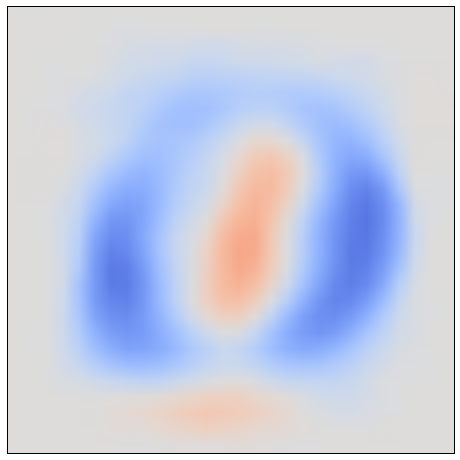

Principal Vector 5


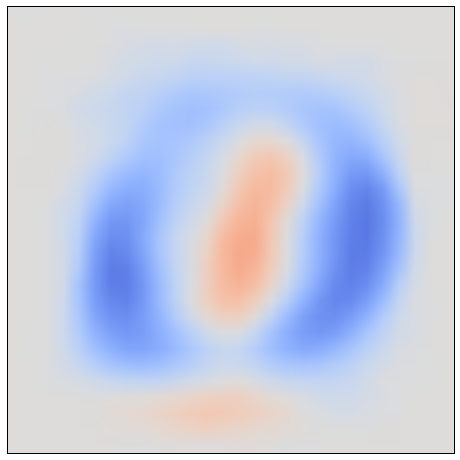

Principal Vector 6


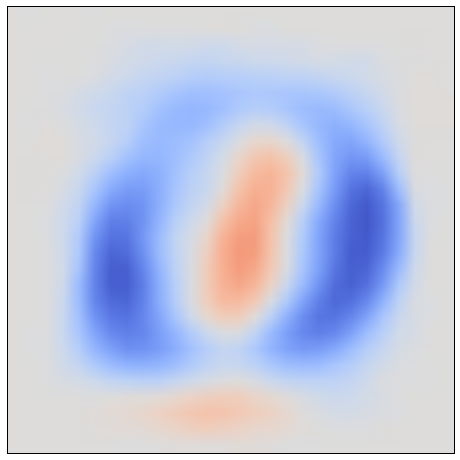

Principal Vector 7


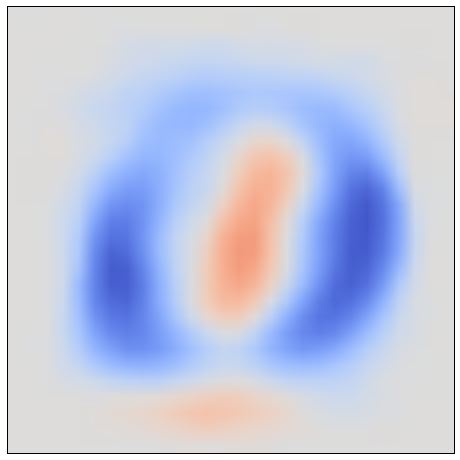

Principal Vector 8


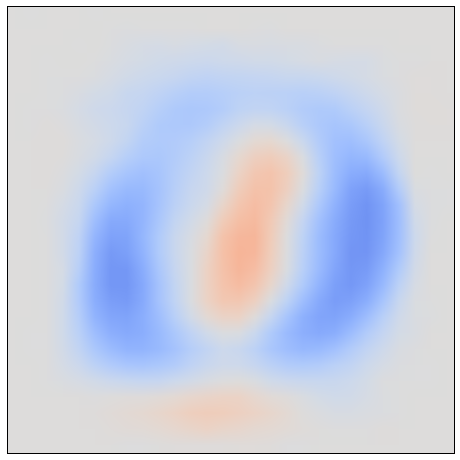

Principal Vector 9


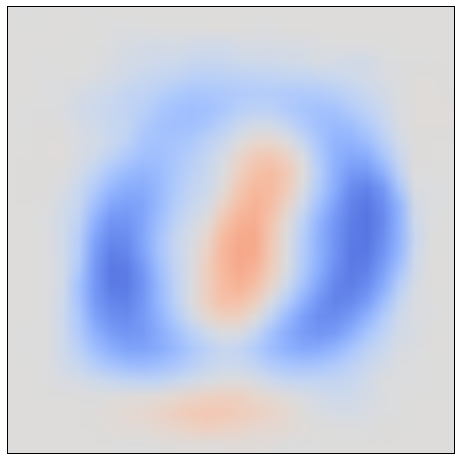

Principal Vector 10


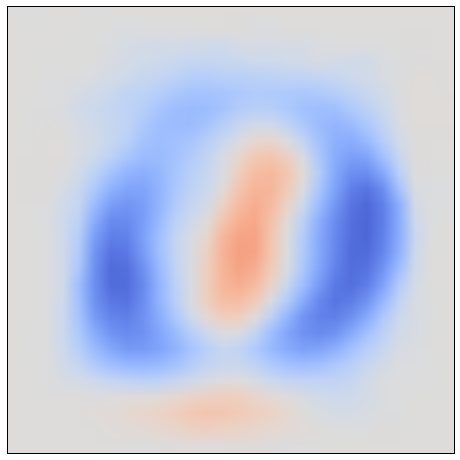

In [28]:
for i in range(10):
    print("Principal Vector {}".format(i+1))
    fig, ax = plt.subplots()
    cur_img = principal_vectors[i].reshape(image_shape)
    #center up on the min and max so our color scale has zero at grey
    vmin = np.min(cur_img)
    vmax = np.max(cur_img)
    vmin = min(vmin, -vmax)
    vmax = max(-vmin, vmax)
    ax.imshow(principal_vectors[0].reshape(image_shape), cmap="coolwarm", vmin=vmin, vmax=vmax)
    remove_ticks_and_labels(fig)
    plt.show()

# Covariance Matrix

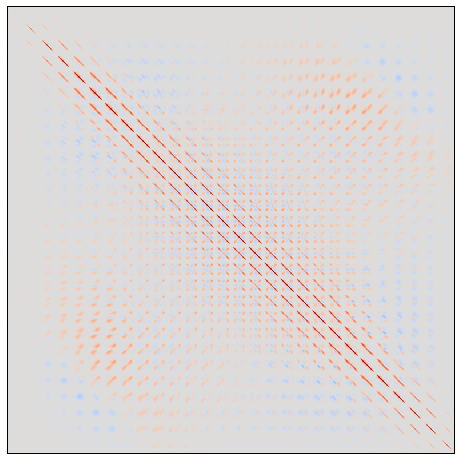

In [30]:
covar = np.dot(whitened_images.transpose(), whitened_images)/len(whitened_images)
fig, ax = plt.subplots()
vmax = np.max(covar)
vmin = -vmax
ax.imshow(covar, interpolation="nearest", vmin=vmin, vmax=vmax, cmap="coolwarm")
remove_ticks_and_labels(fig)

# Fin